In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

In [2]:
uniref90_aligned_binary_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_binary.csv")
uniref90_aligned_multi_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_multi.csv")
uniprot_aligned_binary_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_binary.csv")
uniprot_aligned_multi_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_multi.csv")

In [23]:
spike_protein_domain_map = {
    "NTD": [14, 305],
    "S1 Subunit": [14, 685],
    "S2 Subunit": [686, 1273],
    "RBD": [319, 541],
    "FP": [788, 806],
    "HR1": [912, 984],
    "HR2": [1163, 1213]
}

def annotate_region(pos, region):
    pos = int(pos)
    start = spike_protein_domain_map[region][0]
    end = spike_protein_domain_map[region][1]
    if (int(pos) >= start and int(pos) <= end):
        if region == "RBD":
            print(f"{pos} >= {start} = {pos >= start}")
            print(f"{pos} <= {end} = {pos >= end}")
        return 1
    else:
        return 0

In [4]:
file_paths = [uniref90_aligned_binary_file_path, uniref90_aligned_multi_file_path, uniprot_aligned_binary_file_path, uniprot_aligned_multi_file_path]
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df.rename(columns={"uniref90_id": "id", "uniprot_id": "id"}, inplace=True)
    dfs.append(df[["id", "Human", "y_true", "orig_token", "perturb_seq_pos", "new_token", "Human_pred_diff", "abs_Human_pred_diff", "perturb_pos", "experiment"]])
df = pd.concat(dfs)
df = df[~df["perturb_seq_pos"].isna()]
df.shape

(5618, 10)

In [5]:
df["perturb_seq_pos"] = df["perturb_seq_pos"].astype("Int64")
df["perturbation_id"] = df.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
df.columns

Index(['id', 'Human', 'y_true', 'orig_token', 'perturb_seq_pos', 'new_token',
       'Human_pred_diff', 'abs_Human_pred_diff', 'perturb_pos', 'experiment',
       'perturbation_id'],
      dtype='object')

In [6]:
df.head()

,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,experiment,perturbation_id
0,UniRef90_A0A8B6RAI1,0.590175,Human,I,402,L,0.397972,0.397972,1069,sarscov2-uniref90-aligned-binary,402_L
1,UniRef90_A0A8B6RAI1,0.571952,Human,V,401,L,0.416195,0.416195,1068,sarscov2-uniref90-aligned-binary,401_L
2,UniRef90_A0A8B6RAI1,0.863793,Human,Q,409,L,0.124355,0.124355,1076,sarscov2-uniref90-aligned-binary,409_L
3,UniRef90_A0A8B6RAI1,0.741563,Human,R,403,L,0.246585,0.246585,1070,sarscov2-uniref90-aligned-binary,403_L
4,UniRef90_A0A8B6RJG7,0.852662,Human,Q,409,L,0.135195,0.135195,1076,sarscov2-uniref90-aligned-binary,409_L


In [7]:
len(df["perturb_seq_pos"].unique())

187

In [8]:
experiment_counts = df["experiment"].value_counts().to_dict()
experiment_counts

{'sarscov2-uniref90-aligned-multi': 3139,
 'sarscov2-uniprot-aligned-multi': 2073,
 'sarscov2-uniref90-aligned-binary': 301,
 'sarscov2-uniprot-aligned-binary': 105}

In [9]:
df_1 = df[["id", "perturb_seq_pos", "experiment"]].groupby(["perturb_seq_pos", "experiment"]).count()
df_1 = df_1.reset_index()
df_1["proportion"] = df_1.apply(lambda x: x["id"]/experiment_counts[x["experiment"]], axis=1)
 
df_1_pivot = df_1.pivot(columns="experiment", index="perturb_seq_pos", values="proportion")
df_1_pivot

experiment,sarscov2-uniprot-aligned-binary,sarscov2-uniprot-aligned-multi,sarscov2-uniref90-aligned-binary,sarscov2-uniref90-aligned-multi
perturb_seq_pos,,,,
1,NaN,NaN,NaN,0.000319
2,NaN,NaN,NaN,0.005734
3,NaN,NaN,NaN,0.007646
4,NaN,NaN,NaN,0.019433
5,NaN,NaN,NaN,0.016247
...,...,...,...,...
584,NaN,0.014954,NaN,NaN
586,NaN,0.012542,NaN,NaN
596,NaN,0.022672,NaN,NaN


In [10]:
# df_2 = df[["Human_pred_diff", "perturb_seq_pos", "experiment"]].groupby(["perturb_seq_pos", "experiment"])["Human_pred_diff"].agg(Max = "max", Mean = "mean")
# df_2 = df_2.reset_index()
# df_2_pivot_mean = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Mean")
# df_2_pivot_max = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Max")

In [11]:
df_2 = df[["Human_pred_diff", "perturb_seq_pos"]].groupby(["perturb_seq_pos"])["Human_pred_diff"].agg(Max_Pred_Diff = "max", Mean_Pred_Diff = "mean")
df_2 = df_2.reset_index()
df_2 = df_2.set_index("perturb_seq_pos")
#df_2_pivot_mean = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Mean")
#df_2_pivot_max = df_2.pivot(index="perturb_seq_pos", columns="experiment", values="Max")

In [24]:
df_3 = df["perturb_seq_pos"].reset_index()
for k in list(spike_protein_domain_map.keys()):
    df_3[k] = df_3.apply(lambda x: annotate_region(x["perturb_seq_pos"], k), axis=1)
#df_3 = df_3[list(spike_protein_domain_map.keys()]
df_3 = df_3.drop(columns="index").set_index("perturb_seq_pos")
df_3.head()

402 >= 319 = True
402 <= 541 = False
401 >= 319 = True
401 <= 541 = False
409 >= 319 = True
409 <= 541 = False
403 >= 319 = True
403 <= 541 = False
409 >= 319 = True
409 <= 541 = False
402 >= 319 = True
402 <= 541 = False
401 >= 319 = True
401 <= 541 = False
403 >= 319 = True
403 <= 541 = False
402 >= 319 = True
402 <= 541 = False
401 >= 319 = True
401 <= 541 = False
403 >= 319 = True
403 <= 541 = False
409 >= 319 = True
409 <= 541 = False
401 >= 319 = True
401 <= 541 = False
402 >= 319 = True
402 <= 541 = False
403 >= 319 = True
403 <= 541 = False
402 >= 319 = True
402 <= 541 = False
401 >= 319 = True
401 <= 541 = False
403 >= 319 = True
403 <= 541 = False
401 >= 319 = True
401 <= 541 = False
403 >= 319 = True
403 <= 541 = False
402 >= 319 = True
402 <= 541 = False
409 >= 319 = True
409 <= 541 = False
403 >= 319 = True
403 <= 541 = False
401 >= 319 = True
401 <= 541 = False
402 >= 319 = True
402 <= 541 = False
403 >= 319 = True
403 <= 541 = False
409 >= 319 = True
409 <= 541 = False
4

484 <= 541 = False
488 >= 319 = True
488 <= 541 = False
402 >= 319 = True
402 <= 541 = False
491 >= 319 = True
491 <= 541 = False
408 >= 319 = True
408 <= 541 = False
408 >= 319 = True
408 <= 541 = False
408 >= 319 = True
408 <= 541 = False
483 >= 319 = True
483 <= 541 = False
487 >= 319 = True
487 <= 541 = False
482 >= 319 = True
482 <= 541 = False
490 >= 319 = True
490 <= 541 = False
416 >= 319 = True
416 <= 541 = False
403 >= 319 = True
403 <= 541 = False
409 >= 319 = True
409 <= 541 = False
408 >= 319 = True
408 <= 541 = False
485 >= 319 = True
485 <= 541 = False
409 >= 319 = True
409 <= 541 = False
408 >= 319 = True
408 <= 541 = False
408 >= 319 = True
408 <= 541 = False
485 >= 319 = True
485 <= 541 = False
409 >= 319 = True
409 <= 541 = False
491 >= 319 = True
491 <= 541 = False
416 >= 319 = True
416 <= 541 = False
484 >= 319 = True
484 <= 541 = False
484 >= 319 = True
484 <= 541 = False
407 >= 319 = True
407 <= 541 = False
408 >= 319 = True
408 <= 541 = False
414 >= 319 = True
4

513 >= 319 = True
513 <= 541 = False
513 >= 319 = True
513 <= 541 = False
517 >= 319 = True
517 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
502 >= 319 = True
502 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
533 >= 319 = True
533 <= 541 = False
5

,NTD,S1 Subunit,S2 Subunit,RBD,FP,HR1,HR2
perturb_seq_pos,,,,,,,
402,0,1,0,1,0,0,0
401,0,1,0,1,0,0,0
409,0,1,0,1,0,0,0
403,0,1,0,1,0,0,0
409,0,1,0,1,0,0,0


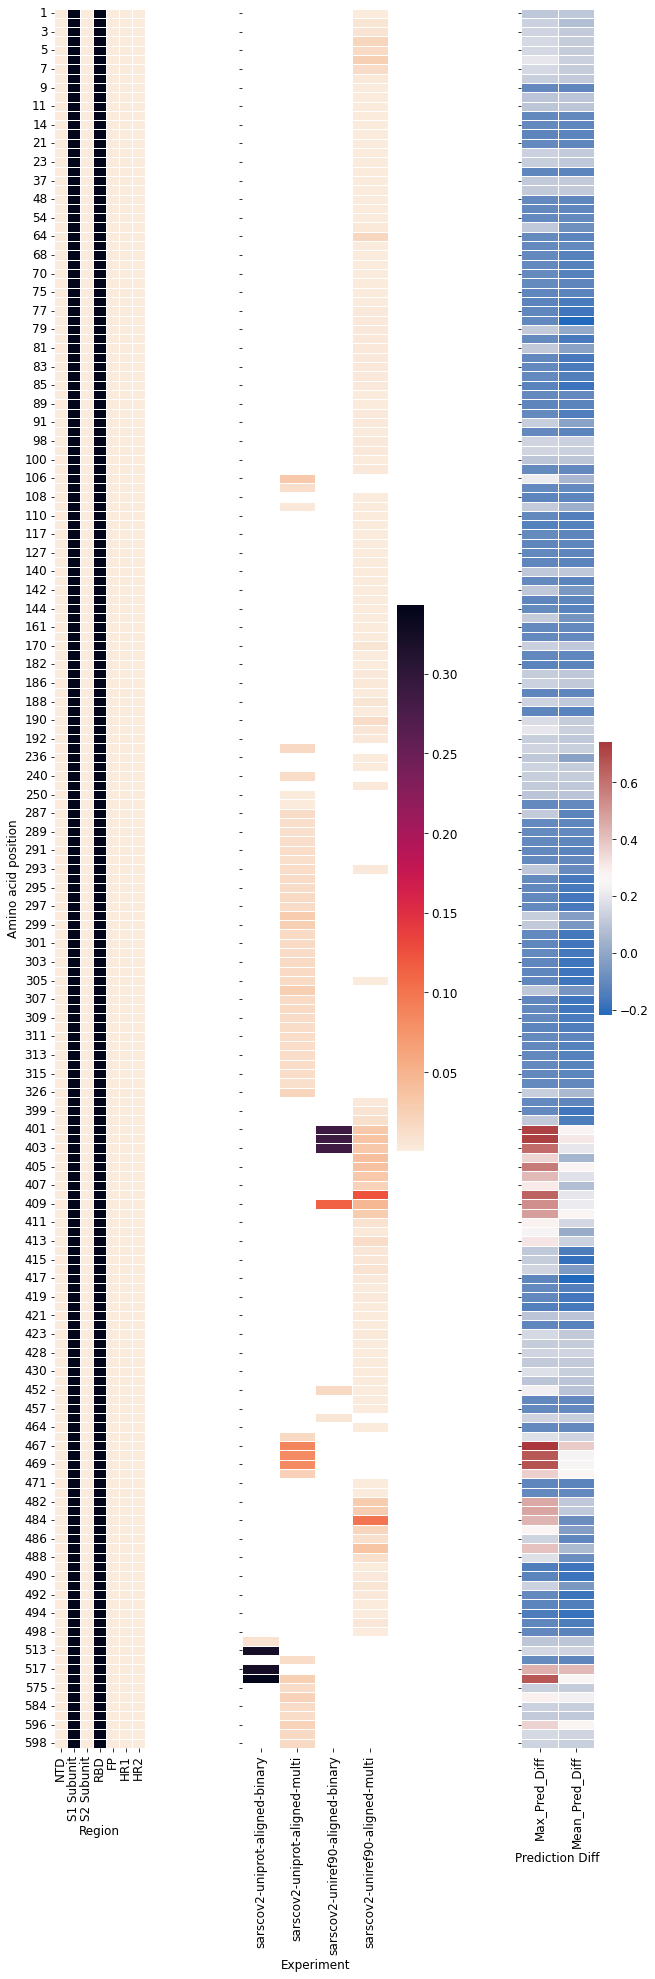

In [21]:
cmap = sns.color_palette("vlag", as_cmap=True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update({'font.size': 12})
fig, ax =plt.subplots(1,3,figsize=(10, 32), sharey=True, gridspec_kw={'width_ratios': [1, 2, 1]})
sns.heatmap(df_3, linewidth=.5, ax=ax[0], vmin=0, vmax=1, cmap=sns.cm.rocket_r, cbar=False)
ax[0].set_xlabel("Region")
ax[0].set_ylabel("Amino acid position")
sns.heatmap(df_1_pivot, linewidth=.5, ax=ax[1], cmap=sns.cm.rocket_r)
ax[1].set_xlabel("Experiment")
ax[1].set_ylabel("")
sns.heatmap(df_2, linewidth=.5, ax=ax[2], cmap=cmap)
ax[2].set_xlabel("Prediction Diff")
ax[2].set_ylabel("")
# sns.heatmap(df_2_pivot_max, linewidth=.5, ax=ax[2])
#ax[2].set_xlabel("Prediction Diff", 12)
#ax[2].set_ylabel("")

#ax[1].legend(loc='right', bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout(pad=5.0)
plt.subplots_adjust(wspace=.8)
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="10")
plt.show()